### Initializing the Sagemaker Instance and its Session

In [ ]:
!pip install sagemaker ipywidgets --upgrade --quiet

In [ ]:
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

### Importing the Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras import Input
from keras.layers import Conv2D, Dense, BatchNormalization, Flatten,  Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import DenseNet121
from keras.utils import plot_model

### Importing the Dataset for Preprocessing and Model

In [2]:
diseaseTypes = ['COVID', 'non-COVID']

trainDir = dataDir = './Datasets/COVID_19_Chest_CT_1'
trainData = []

for index, sp in enumerate(diseaseTypes) :
    for file in os.listdir(os.path.join(trainDir, sp)) :
        trainData.append([sp + '/' + file, index, sp])

trainDataset = pd.DataFrame(trainData, columns= ['File', 'ID', 'Disease Type'])
trainDataset

,File,ID,Disease Type
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (995).png,1,non-COVID
2477,non-COVID/Non-Covid (996).png,1,non-COVID
2478,non-COVID/Non-Covid (997).png,1,non-COVID
2479,non-COVID/Non-Covid (998).png,1,non-COVID


### Arranging the Dataset in a random order

,File,ID,Disease Type
0,COVID/Covid (1227).png,0,COVID
1,COVID/Covid (430).png,0,COVID
2,non-COVID/Non-Covid (322).png,1,non-COVID
3,non-COVID/Non-Covid (379).png,1,non-COVID
4,COVID/Covid (609).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (24).png,1,non-COVID
2477,COVID/Covid (858).png,0,COVID
2478,COVID/Covid (89).png,0,COVID
2479,non-COVID/Non-Covid (1036).png,1,non-COVID


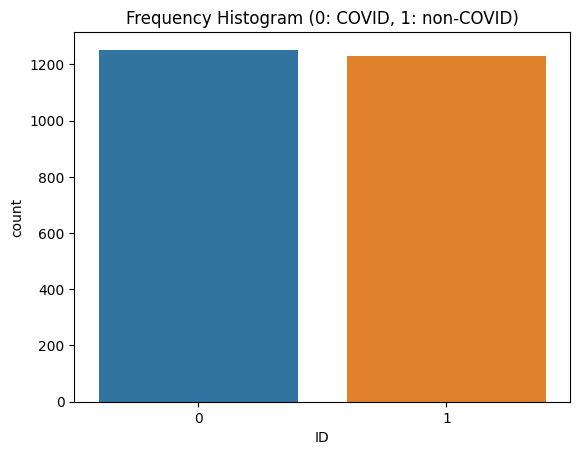

In [3]:
seed = 42
trainDataset = trainDataset.sample(frac=1, replace=False, random_state=seed)
trainDataset = trainDataset.reset_index(drop=True)

sns.countplot(x = "ID", data=trainDataset).set_title("Frequency Histogram (0: COVID, 1: non-COVID)")
trainDataset

### Dataset Sample Visualization

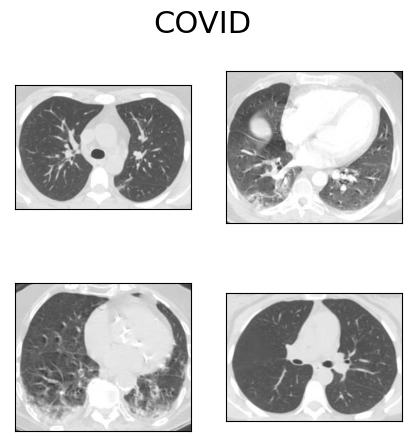

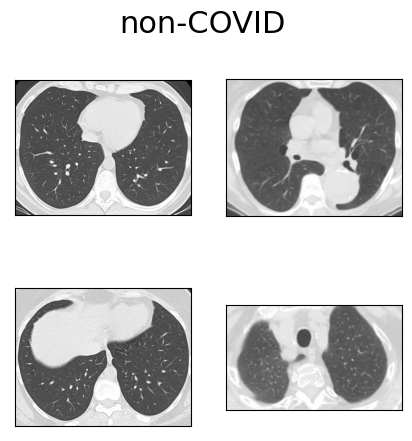

In [4]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(5, 5))
    defect_files = trainDataset['File'][trainDataset['Disease Type'] == defect_types].values
    n = 0
    fig.suptitle(defect_types, fontsize = 22, color = "black")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(dataDir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('COVID', 2, 2)
plot_defects('non-COVID', 2, 2)

### Preprocessing the Dataset

In [5]:
imageSize = 224
def readImage(filePath) :
    return cv2.imread(os.path.join(dataDir, filePath))

def resizeImage(image, imageSize) :
    return cv2.resize(image.copy(), imageSize, interpolation=cv2.INTER_AREA)

In [6]:
trainNumpy = np.zeros((trainDataset.shape[0], imageSize, imageSize, 3))

for i, file in enumerate(trainDataset['File'].values) :
    image = readImage(file)
    if image is not None :
        trainNumpy[i] = resizeImage(image, (imageSize, imageSize))

trainNumpy = trainNumpy / 255.0
print("Train Dataset Shape: ", trainNumpy.shape)

testNumpy = to_categorical(trainDataset['ID'].values, num_classes=2)
print("Test Dataset Shape: ", testNumpy.shape)

Train Dataset Shape:  (2481, 224, 224, 3)
Test Dataset Shape:  (2481, 2)


In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(trainNumpy, testNumpy, test_size=0.2, random_state=seed)
print("X - Train Shape: ", xtrain.shape)
print("X - Test Shape: ", xtest.shape)
print("Y - Train Shape: ", ytrain.shape)
print("Y - Test Shape: ", ytest.shape)

X - Train Shape:  (1984, 224, 224, 3)
X - Test Shape:  (497, 224, 224, 3)
Y - Train Shape:  (1984, 2)
Y - Test Shape:  (497, 2)


### Building the Model and Modifying for Cuckoo Search

In [8]:
def buildModel(imageSize, channels) :
    denseNet = DenseNet121(include_top=False, weights="imagenet")
    input = Input(shape=(imageSize, imageSize, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = denseNet(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(rate=0.25)(x)
    x = Flatten()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x)
    model = Model(input, output)
    for layer in denseNet.layers:
        layer.trainable = False

    optimizer = Adam(learning_rate = 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

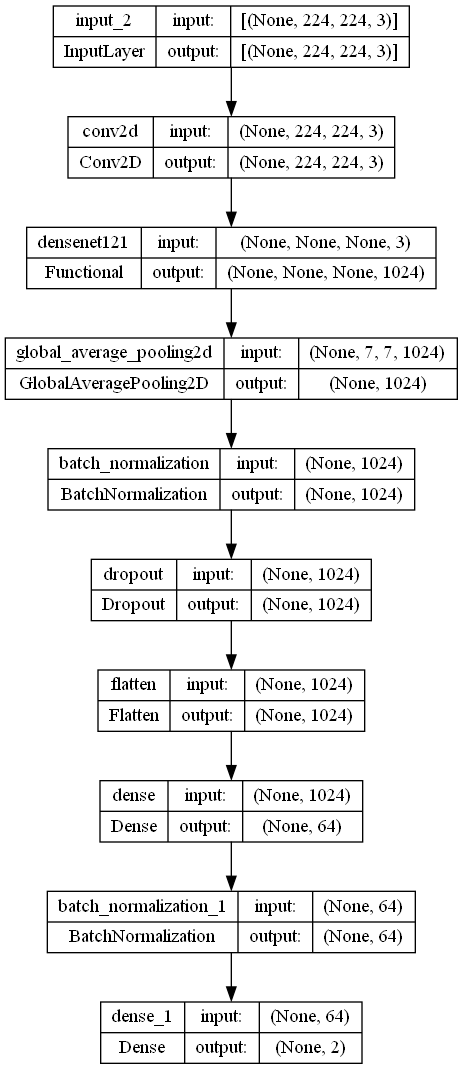

In [9]:
channels = 3

model = buildModel(imageSize, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.70, patience = 5, verbose = 1, min_lr = 1e-4)
checkpoint = ModelCheckpoint('./SavedModels/Pretrained_DenseNet121/DenseNet121_BestModel.h5', verbose = 1, save_best_only = True)

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip = True)
datagen.fit(xtrain)

plot_model(model, to_file = './Plot_Images/Model_Architecture.png', show_shapes = True, show_layer_names = True)

### Training the Dataset with the created Model

In [10]:
BATCH_SIZE = 32
EPOCHS = 10

hist = model.fit(datagen.flow(xtrain, ytrain, batch_size = BATCH_SIZE),
               steps_per_epoch = xtrain.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer, checkpoint],
               validation_data = (xtest, ytest))

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.8846 - accuracy: 0.5675 
Epoch 1: val_loss improved from inf to 0.66626, saving model to ./SavedModels/Pretrained_DenseNet121\DenseNet121_BestModel.h5
62/62 [==============================] - 1457s 20s/step - loss: 0.8846 - accuracy: 0.5675 - val_loss: 0.6663 - val_accuracy: 0.6157 - lr: 0.0030
Epoch 2/10
49/62 [======================>.......] - ETA: 3:40 - loss: 0.6426 - accuracy: 0.6792